# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "S7-VAF.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.



---

monkey population data

In [5]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

---

VAF for monkeys

In [26]:
@utility.report
def plot_VAF_monkeys(ax, full_list_MCx, allDFs):
    defs = monkey_defs
    field = defs.areas[2]+'_rates'
    
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))
    
    dfpairs = [(allDFs[i], allDFs[j]) for i,j in pairFileList1]
    
    VAFs = np.zeros((defs.n_components, len(dfpairs)*2))
    for i,(df1, df2) in enumerate(dfpairs):
        a,b = dt.VAF_pyal(df1=df1, field1=field, epoch1=defs.exec_epoch,
                          df2=df2, field2=field, epoch2=defs.exec_epoch, n_components=defs.n_components)
        VAFs[:,2*i] = a.cumsum()
        VAFs[:,2*i+1] = b.cumsum()
        
    # plotting
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, VAFs, color=params.colors.MainCC, marker = 'o', zorder=1, label='CCA')
    # ax.plot(x_, VAFs, lw=.4, alpha=.2, zorder=0)
    
    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('CCA VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])


Executed: `plot_VAF_monkeys` in 95.2s


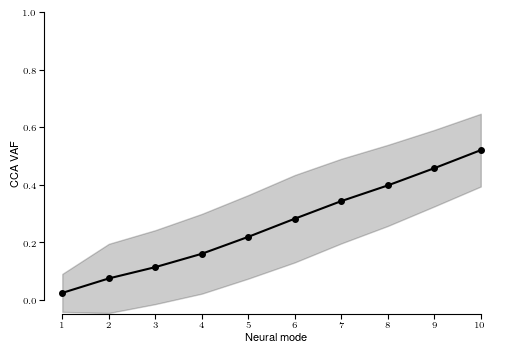

In [27]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    # full_list_MCx, allDFs = get_full_monkey_data()
    
    plot_VAF_monkeys(ax, full_list_MCx, allDFs)
    

---
PCA VAF for monkeys

In [22]:
def plot_monkey_pca_vaf(ax, allDFs, epoch=None , n_components:int = 10):
    defs = monkey_defs
    field = defs.areas[2]+'_rates'
    
    VAFs = np.empty((n_components, len(allDFs)))*np.nan
    for session, df in enumerate(allDFs):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch) if epoch is not None else df
        rates = np.concatenate(df_[field].values, axis=0)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates)
        VAFs[:,session] = np.cumsum(rates_model.explained_variance_ratio_)


    # plotting

    x_ = np.arange(1,n_components+1)
    utility.shaded_errorbar(ax, x_, VAFs, color=params.colors.UpperCC, marker = 'o', zorder=1, label='PCA')
    # ax.plot(x_, VAFs, lw=.4, alpha=.2, zorder=0)
    
    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('PCA VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])


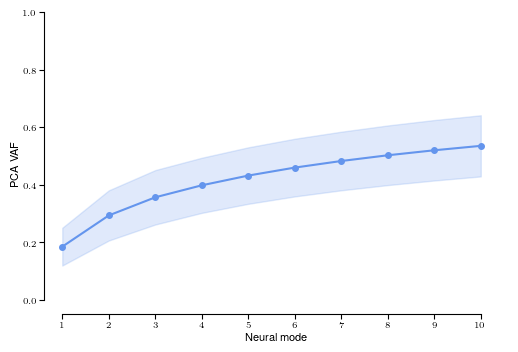

In [23]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    # full_list_MCx, allDFs = get_full_monkey_data()
    
    plot_monkey_pca_vaf(ax, allDFs, epoch=monkey_defs.exec_epoch)

---

Mouse CCA plot

In [9]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

---
VAF for mice

In [28]:
@utility.report
def plot_VAF_mice(ax, allDFs_M1, area = 'M1'):
    defs = mouse_defs
    field = area+'_rates'
    
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    
    dfpairs = [(allDFs_M1[i], allDFs_M1[j]) for i,j in pairFileList1]
    
    VAFs = np.empty((defs.n_components, len(dfpairs)*2))*np.nan
    for i,(df1, df2) in enumerate(dfpairs):
        a,b = dt.VAF_pyal(df1=df1, field1=field, epoch1=defs.exec_epoch,
                          df2=df2, field2=field, epoch2=defs.exec_epoch, n_components=defs.n_components)
        VAFs[:,2*i] = a.cumsum()
        VAFs[:,2*i+1] = b.cumsum()
        
    # plotting
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, VAFs, color=params.colors.MainCC, marker = 'o', zorder=1)
    # ax.plot(x_, VAFs, lw=.4, alpha=.2, zorder=0)

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('CCA VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])


Executed: `plot_VAF_mice` in 1.4s


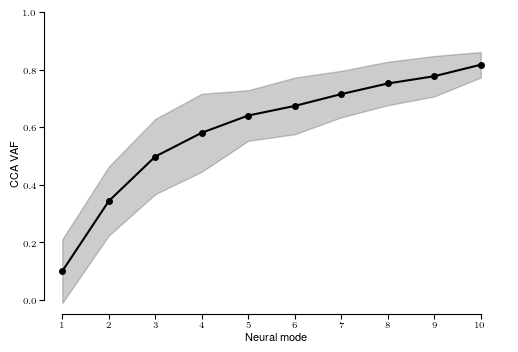

In [29]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=1,)

    ax = fig.add_subplot(gs[0])

    
    # allDFs_M1, _ = get_full_mouse_data()
    
    plot_VAF_mice(ax, allDFs_M1)
    
    plt.show()

---
plot mouse PCA VAF

In [30]:
def plot_mouse_pca_vaf(ax, allDFs, field='M1_rates'):
    defs = mouse_defs
    
    
    VAFs = np.empty((defs.n_components, len(allDFs)))*np.nan
    for session, df in enumerate(allDFs):
        df_ = pyal.restrict_to_interval(df, epoch_fun=mouse_defs.exec_epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates_model = PCA(n_components=defs.n_components, svd_solver='full').fit(rates)
        VAFs[:,session] = np.cumsum(rates_model.explained_variance_ratio_)

        
    # plotting
    
    x_ = np.arange(1,defs.n_components+1)
    utility.shaded_errorbar(ax, x_, VAFs, color=params.colors.UpperCC, marker = 'o', zorder=1, label='PCA')
    
    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylabel('PCA VAF')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,defs.n_components])
    ax.spines['left'].set_bounds([0,1])


Executed: `plot_VAF_mice` in 1.4s


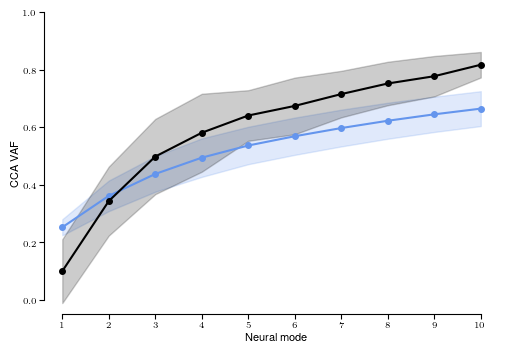

In [37]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=1,)

    ax = fig.add_subplot(gs[0])

    
    # allDFs_M1, _ = get_full_mouse_data()
    plot_mouse_pca_vaf(ax, allDFs_M1, field='M1_rates')
    
    plot_VAF_mice(ax, allDFs_M1)
    
    plt.show()

# Part 2
Plot figure

Executed: `get_full_monkey_data` in 40.1s
Executed: `plot_VAF_monkeys` in 107.6s
Executed: `get_full_mouse_data` in 1.8s
Executed: `plot_VAF_mice` in 2.4s
Executed: `plot_VAF_mice` in 2.6s


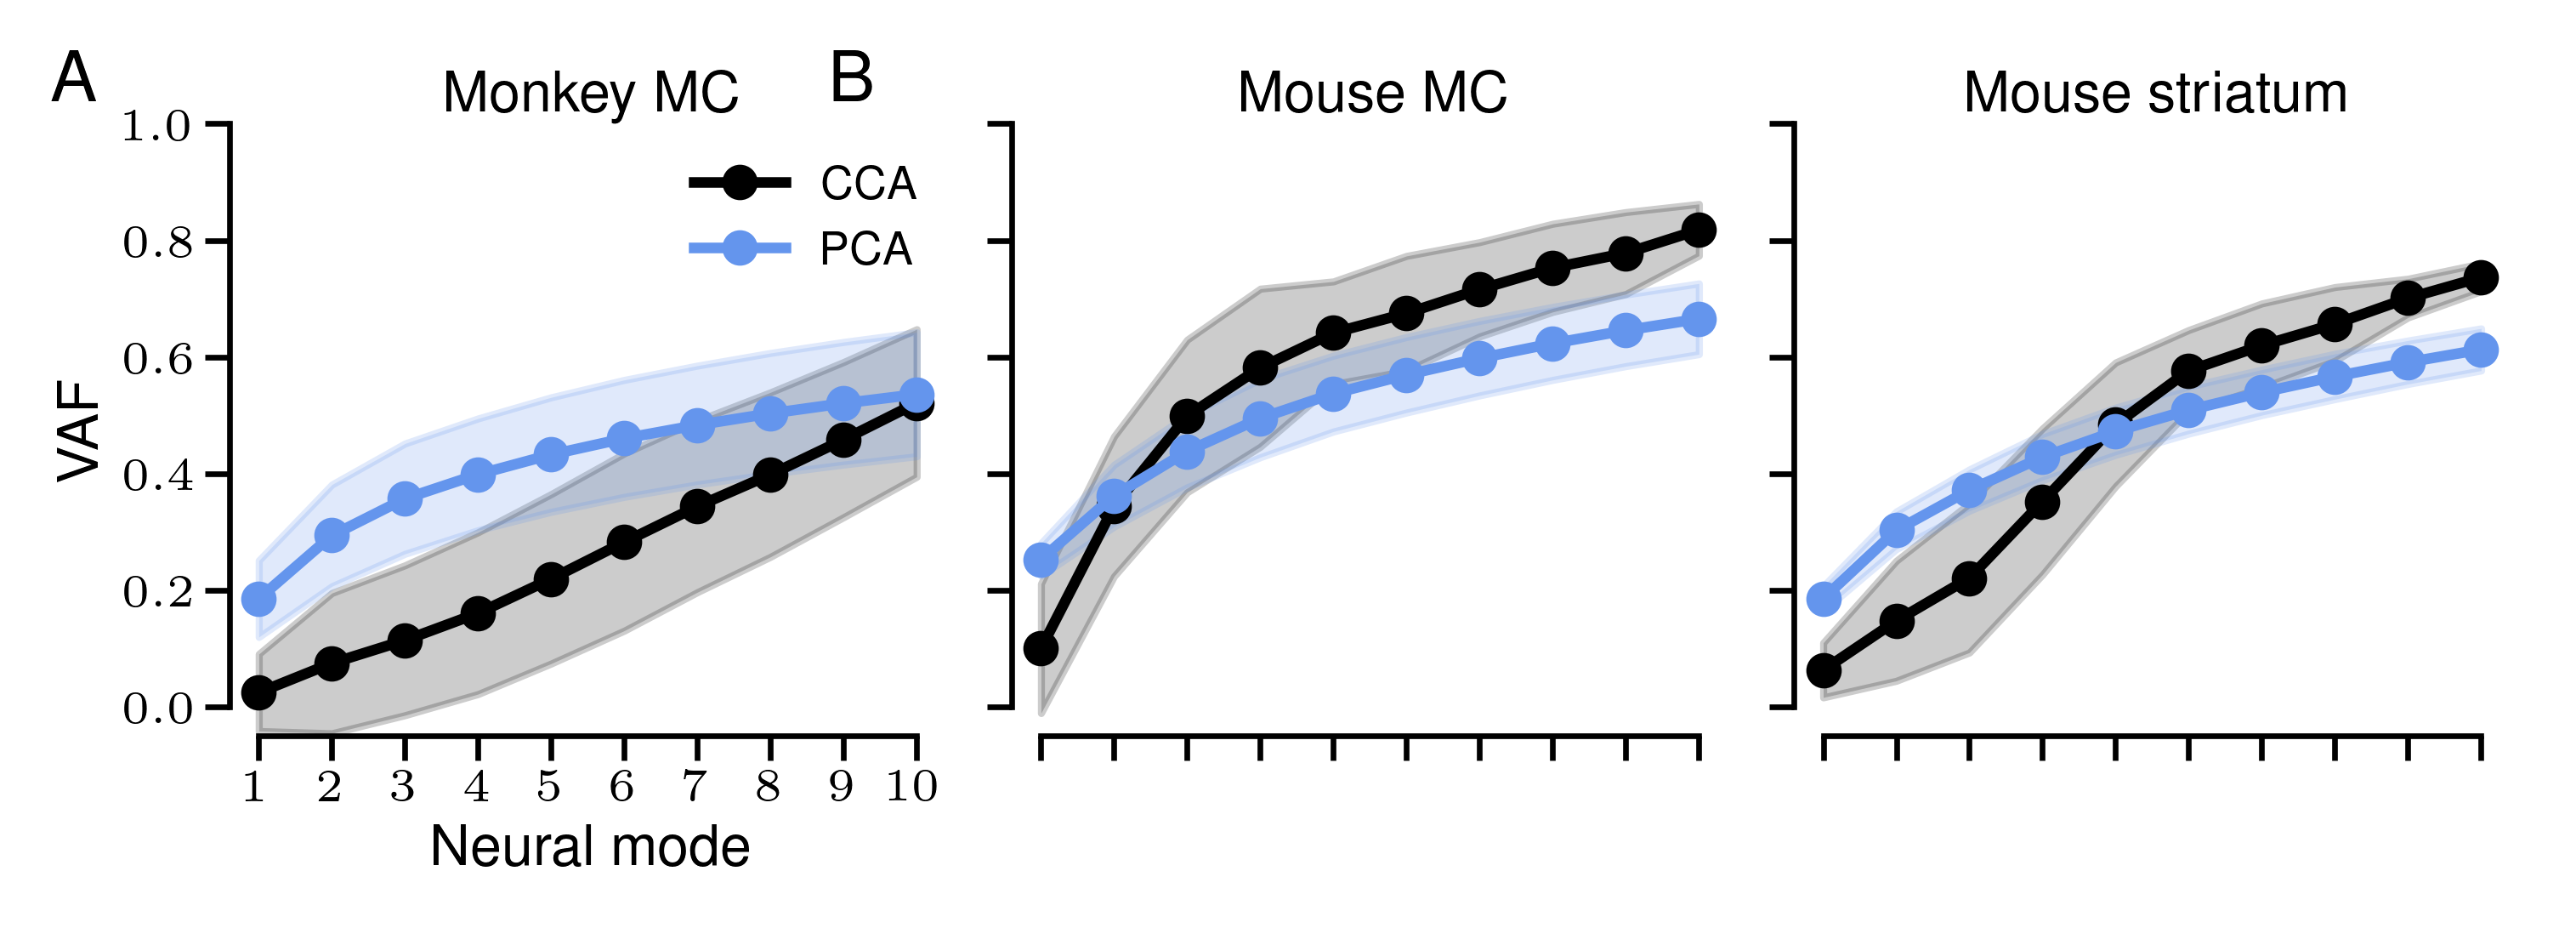

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    

    
    ##########################################
    # 3: Monkey VAF
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=3,
                                    left=0,
                                    bottom=0,
                                    width=params.panels.cca[0]*3,
                                    height=params.panels.cca[1],
                                    wspace=.07)


    ax3 = fig.add_subplot(gs3[0])
    
    full_list_MCx, allDFs = get_full_monkey_data()

    plot_VAF_monkeys(ax3, full_list_MCx, allDFs)
    ax3.text(.5,1,'Monkey MC', fontsize = mpl.rcParams['axes.titlesize'],
             va='bottom', ha='center', transform=ax3.transAxes)
    
    plot_monkey_pca_vaf(ax3, allDFs, epoch=monkey_defs.exec_epoch, n_components=monkey_defs.n_components)
    
    ax3.legend()
    
    ax3.set_ylabel('VAF')
    
    
    
    ##########################################
    # 4: Mouse VAF

    allDFs_M1, allDFs_Str = get_full_mouse_data()

    ax4 = fig.add_subplot(gs3[1])
    plot_VAF_mice(ax4, allDFs_M1)
    plot_mouse_pca_vaf(ax4, allDFs_M1, field='M1_rates')

    ax5 = fig.add_subplot(gs3[2])
    plot_VAF_mice(ax5, allDFs_Str, area='Str')
    plot_mouse_pca_vaf(ax5, allDFs_Str, field='Str_rates')
    
    for ax in (ax4,ax5):
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    ax4.text(.5,1,'Mouse MC', fontsize = mpl.rcParams['axes.titlesize'],
             va='bottom', ha='center', transform=ax4.transAxes)
    ax5.text(.5,1,'Mouse striatum', fontsize = mpl.rcParams['axes.titlesize'],
             va='bottom', ha='center', transform=ax5.transAxes)
    
    
    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax3,ax4)
    OFFX=np.array([.05]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    # OFFX[[-1]]=0.02
#     OFFX[[0,2,3,4,5,6,7,8]]=0.05
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(params.figPath / 'figureS7-VAF.pdf', format='pdf', bbox_inches='tight')